# ITSM Ticket Similarity - Model Fine-tuning (v6 Refactored)

**Version 6 Refactored** improves upon the original v6 by:
1. **Robust Environment Setup:** Automatically handles NLTK data and library dependencies (Kaggle/Local).
2. **Improved Pipeline:** Cleaner data loading and preprocessing.
3. **Contextual Embeddings:** Retains the structured input format `[Service] [Category] Description`.
4. **Reliable Logging:** Auto-detects the best location for logs.


# 1 . Environment Setup

In [1]:
import os, sys, subprocess
from pathlib import Path
try:
    import importlib.metadata as importlib_metadata
except ImportError:
    import importlib_metadata

def installed_packages(names):
    installed = []
    for name in names:
        try:
            importlib_metadata.version(name)
            installed.append(name)
        except importlib_metadata.PackageNotFoundError:
            pass
    return installed

# Remove preinstalled packages that demand newer numpy/sklearn and trigger resolver errors.
to_remove = installed_packages(['cesium', 'umap-learn'])
if to_remove:
    subprocess.run([sys.executable, '-m', 'pip', 'uninstall', '-y', *to_remove], check=False)

%pip install -q numpy==1.26.4 scikit-learn==1.3.2 imbalanced-learn==0.12.0

def ensure_packages(pkgs):
    missing = []
    for name, spec in pkgs.items():
        try:
            importlib_metadata.version(name)
        except importlib_metadata.PackageNotFoundError:
            missing.append(spec)
    if missing:
        print('📦 Installing:', ', '.join(missing))
        subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet', *missing])

def ensure_nltk(resources=("wordnet","omw-1.4","stopwords","punkt")):
    import nltk
    nltk_data = Path.home() / "nltk_data"
    nltk_data.mkdir(exist_ok=True)
    if str(nltk_data) not in nltk.data.path:
        nltk.data.path.append(str(nltk_data))
    for res in resources:
        try:
            nltk.data.find(f"corpora/{res}")
        except LookupError:
            try:
                nltk.data.find(f"tokenizers/{res}")
            except LookupError:
                print(f"⬇️ Downloading NLTK: {res}")
                nltk.download(res, quiet=True, download_dir=str(nltk_data))

    # 4. Pre-download SentenceTransformer model to cache (avoid runtime download delays)
    try:
        from sentence_transformers import SentenceTransformer
        cache_dir = Path(os.environ.get('TRANSFORMERS_CACHE', Path.home() / '.cache' / 'huggingface' / 'hub'))
        cache_dir.mkdir(parents=True, exist_ok=True)
        os.environ['TRANSFORMERS_CACHE'] = str(cache_dir)
        os.environ['SENTENCE_TRANSFORMERS_HOME'] = str(cache_dir)
        print(f'⬇️ Pre-downloading model to cache: sentence-transformers/all-mpnet-base-v2 -> {cache_dir}')
        SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device='cpu')
        print('✅ Model cached.')
    except Exception as e:
        print(f'⚠️ Model pre-download failed: {e}')

def run_setup():
    os.environ['WANDB_DISABLED'] = 'true'
    os.environ['WANDB_MODE'] = 'offline'
    os.environ['WANDB_SILENT'] = 'true'
    os.environ['HF_HUB_DISABLE_TELEMETRY'] = '1'
    os.environ['TOKENIZERS_PARALLELISM'] = 'false'
    os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
    os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

    pkgs = {
        'sentence-transformers': 'sentence-transformers>=2.2.2',
        'transformers': 'transformers>=4.38.0',
        'torch': 'torch',
        'torchvision': 'torchvision',
        'torchaudio': 'torchaudio',
        'scikit-learn': 'scikit-learn==1.3.2',
        'imbalanced-learn': 'imbalanced-learn==0.12.0',
        'scipy': 'scipy',
        'numpy': 'numpy==1.26.4',
        'pandas': 'pandas',
        'tqdm': 'tqdm',
        'datasets': 'datasets',
        'joblib': 'joblib',
        'protobuf': 'protobuf<=3.20.1',
        'requests': 'requests',
        'python-dotenv': 'python-dotenv',
        'openai': 'openai',
        'seaborn': 'seaborn',
        'matplotlib': 'matplotlib',
        'pytorch-lightning': 'pytorch-lightning',
    }
    ensure_packages(pkgs)
    ensure_nltk()
    print(importlib_metadata.version('imbalanced-learn'))
    print(importlib_metadata.version('scikit-learn'))

run_setup()


Note: you may need to restart the kernel to use updated packages.
⬇️ Downloading NLTK: wordnet
⬇️ Downloading NLTK: omw-1.4
⬇️ Downloading NLTK: wordnet
⬇️ Downloading NLTK: omw-1.4


E0000 00:00:1764583907.224530     681 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764583907.231052     681 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

⬇️ Pre-downloading model to cache: sentence-transformers/all-mpnet-base-v2 -> /root/.cache/huggingface/hub


/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ Model cached.
0.12.0
1.3.2


#3. Model Configuration and Loading

In [ ]:
import logging
import random
import numpy as np
import torch
if 'log' not in globals() or not callable(log):
    def log(msg, level=logging.INFO):
        print(msg)
# --- CONFIGURATION ---
CONFIG = {
    'model_name': 'sentence-transformers/all-mpnet-base-v2',
    'output_dir': 'models/v6_refactored_finetuned', # New output directory
    'source_data': 'data/dummy_data_promax.csv', # Will try to resolve this
    'relationship_data': 'data/relationship_pairs.json', # For relationship classifier
    
    # Hyperparameters
    'epochs': 5,
    'batch_size': 16,
    'lr': 2e-5,
    'max_seq_length': 384,
    
    # Data Strategy
    'num_pairs': 2000,
    'pos_ratio': 0.4,   # 40% Positive, 60% Negative
    'neg_mining_range': (0.2, 0.5), # TF-IDF score range for "Hard Negatives"
    'eval_split': 0.15, # % of data for validation
    
    # Seed
    'seed': 42
}

# Set Seeds
random.seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
torch.manual_seed(CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG['seed'])
    log(f"🚀 CUDA Detected: {torch.cuda.get_device_name(0)}")
else:
    log("⚠️ CUDA Not Detected. Running on CPU.")


🚀 CUDA Detected: Tesla T4


In [ ]:
import pandas as pd
import re
from pathlib import Path
def resolve_data_path(path_str):
    """Smart path resolver for Local/Kaggle/Colab/Agent envs."""
    # 1. As-is
    p = Path(path_str)
    if p.exists(): return p.resolve()
    
    # 2. Relative to current script location (for agent or local execution)
    # Using Path.cwd() as a robust base for notebooks
    script_dir = Path.cwd() 
    if (script_dir / path_str).exists(): return (script_dir / path_str).resolve()

    # 3. Common Kaggle/Colab input paths
    # Assuming path_str might be like 'data/file.csv'
    base_filename = Path(path_str).name
    
    kaggle_input_dir = Path("/kaggle/input")
    if kaggle_input_dir.exists():
        for dataset_dir in kaggle_input_dir.iterdir():
            if (dataset_dir / base_filename).exists():
                return (dataset_dir / base_filename).resolve()
            if (dataset_dir / path_str).exists(): # if path_str includes subdir like 'data/'
                return (dataset_dir / path_str).resolve()
                
    colab_dir = Path("/content")
    if (colab_dir / path_str).exists(): return (colab_dir / path_str).resolve()

    raise FileNotFoundError(f"Could not find {path_str} in any common locations (cwd, relative, Kaggle, Colab).")

def load_and_preprocess_data(config):
    source_path = resolve_data_path(config['source_data'])
    log(f"📂 Loading incident data from: {source_path}")
    df = pd.read_csv(source_path)
    
    # Required columns for contextual embedding
    required_cols = ["Number", "Short Description", "Description", "Category", "Subcategory", 
                     "Service", "Service offering", "Assignment group"]
    for col in required_cols:
        if col not in df.columns:
            raise ValueError(f"Missing required column: {col}")

    # Fill NA and Clean Text
    # We ensure all context fields are strings
    placeholders = {"", "nan", "none", "null", "unknown", "n/a", "na"}

    def normalize_field(val: str) -> str:
        s = str(val).strip()
        s = re.sub(r"\s+", " ", s) # Replace multiple spaces with single
        if s.lower() in placeholders:
            return ""
        return s

    for col in [c for c in required_cols if c != "Number"]:
        df[col] = df[col].fillna("").apply(normalize_field)

    # Normalize casing for structured context fields to reduce duplicates
    context_cols = ["Service", "Service offering", "Category", "Subcategory", "Assignment group"]
    for col in context_cols:
        df[col] = df[col].str.lower()

    # Construct Rich Text Representation (Contextual Prefixing)
    # Format: [Service | Service offering] [Category | Subcategory] Group: Assignment group. Short Description. Description
    def build_bracketed(parts):
        clean_parts = [p for p in parts if p]
        return f"[{ ' | '.join(clean_parts) }] " if clean_parts else "" 

    df['context_service'] = df.apply(lambda row: build_bracketed([row['Service'], row['Service offering']]), axis=1)
    df['context_category'] = df.apply(lambda row: build_bracketed([row['Category'], row['Subcategory']]), axis=1)
    df['context_group'] = df.apply(lambda row: f"Group: {row['Assignment group']}. " if row['Assignment group'] else "", axis=1)

    df['text'] = (
        df['context_service'] +
        df['context_category'] +
        df['context_group'] +
        df['Short Description'].str.strip() + ". " +
        df['Description'].str.strip()
    ).str.replace(r"\\s+\\.", ".", regex=True) # Remove space before period
    df['text'] = df['text'].str.replace(r"\\s+", " ", regex=True).str.strip() # Clean up excess spaces

    # Filter empty or too short
    initial_count = len(df)
    min_length = 10 # Configurable if needed
    df = df[df['text'].str.len() >= min_length].copy()
    dropped = initial_count - len(df)
    if dropped > 0:
        log(f"⚠️ Dropped {dropped} incidents due to short/empty text after preprocessing.")
    
    # Create unique group ID for stratified splitting (Category-Subcategory)
    df['category_id'] = df.groupby(['Category', 'Subcategory']).ngroup()
    
    log(f"✅ Preprocessed {len(df)} incidents.")
    log(f"Sample preprocessed text: '{df['text'].iloc[0]}'")
    df = df.reset_index(drop=True)
    log(f'✅ Index reset. Range: {df.index.min()} to {df.index.max()}')
    return df

df_incidents = load_and_preprocess_data(CONFIG)


📂 Loading incident data from: /kaggle/input/itsm-dataset/dummy_data_promax.csv
✅ Preprocessed 10000 incidents.
Sample preprocessed text: '[crm (d365, salesforce, genesis, pcube, hussmann services) | bc - basis] [configuration | program bug] Group: piscap l2 workflow. Request: Adjust Configuration/Program bug configuration in CRM (D365, SalesForce, Genesis, PCube, HussMann Services). I encountered an issue where Request: Adjust Configuration/Program bug configuration in CRM (D365, SalesForce, Genesis, PCube, HussMann Services). I'd like assistance to investigate and resolve it.'
✅ Index reset. Range: 0 to 9999
✅ Preprocessed 10000 incidents.
Sample preprocessed text: '[crm (d365, salesforce, genesis, pcube, hussmann services) | bc - basis] [configuration | program bug] Group: piscap l2 workflow. Request: Adjust Configuration/Program bug configuration in CRM (D365, SalesForce, Genesis, PCube, HussMann Services). I encountered an issue where Request: Adjust Configuration/Program bug confi

In [ ]:

from sentence_transformers import InputExample
from tqdm.auto import tqdm
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split

class TextSimilarityCalculator:
    def __init__(self, texts):
        self.lemmatizer = WordNetLemmatizer() if 'wordnet' in nltk.data.path else None
        self.stop_words = set(stopwords.words('english')) if 'stopwords' in nltk.data.path else ENGLISH_STOP_WORDS
        self.vectorizer = TfidfVectorizer(stop_words=list(self.stop_words), max_features=10000)
        log("⏳ Fitting TF-IDF for similarity mining...")
        self.tfidf = self.vectorizer.fit_transform(texts)
        log(f"✅ TF-IDF fit complete. Matrix shape: {self.tfidf.shape}")

    def get_tfidf_similarity(self, idx1, idx2):
        if idx1 >= self.tfidf.shape[0] or idx2 >= self.tfidf.shape[0]:
            return 0.0
        return (self.tfidf[idx1] @ self.tfidf[idx2].T).toarray()[0][0]

def generate_smart_pairs(df, target_count, config):
    df = df.reset_index(drop=True)
    sim_calculator = TextSimilarityCalculator(df['text'].tolist())
    positive_target = int(target_count * config['pos_ratio'])
    negative_target = target_count - positive_target
    pairs = []
    groups = df.groupby('category_id').indices
    valid_groups = {k: list(v) for k, v in groups.items() if len(v) >= 2}
    all_indices = list(df.index)
    log(f"🔎 Generating {positive_target} positive and {negative_target} hard negative pairs...")
    pbar_pos = tqdm(total=positive_target, desc="Generating Positives")
    attempts = 0
    while len(pairs) < positive_target and attempts < positive_target * 5:
        attempts += 1
        if not valid_groups:
            break
        gid = random.choice(list(valid_groups.keys()))
        g_idxs = valid_groups[gid]
        if len(g_idxs) < 2:
            continue
        i1, i2 = random.sample(g_idxs, 2)
        sim = sim_calculator.get_tfidf_similarity(i1, i2)
        if sim > 0.3:
            pairs.append(InputExample(texts=[df.at[i1, 'text'], df.at[i2, 'text']], label=1.0))
            pbar_pos.update(1)
    if len(pairs) < positive_target:
        log(f"⚠️ Filling {positive_target - len(pairs)} remaining positives with random in-group pairs.")
        while len(pairs) < positive_target:
            if not valid_groups:
                break
            gid = random.choice(list(valid_groups.keys()))
            g_idxs = valid_groups[gid]
            if len(g_idxs) < 2:
                continue
            i1, i2 = random.sample(g_idxs, 2)
            pairs.append(InputExample(texts=[df.at[i1, 'text'], df.at[i2, 'text']], label=1.0))
            pbar_pos.update(1)
    pbar_pos.close()
    current_pos_count = len(pairs)
    pbar_neg = tqdm(total=negative_target, desc="Generating Negatives")
    attempts = 0
    max_attempts = negative_target * 10
    while (len(pairs) - current_pos_count) < negative_target and attempts < max_attempts:
        attempts += 1
        i1, i2 = random.sample(all_indices, 2)
        if df.at[i1, 'category_id'] == df.at[i2, 'category_id']:
            continue
        sim = sim_calculator.get_tfidf_similarity(i1, i2)
        min_sim, max_sim = config['neg_mining_range']
        if min_sim <= sim <= max_sim:
            pairs.append(InputExample(texts=[df.at[i1, 'text'], df.at[i2, 'text']], label=0.0))
            pbar_neg.update(1)
    neg_generated = len(pairs) - current_pos_count
    if neg_generated < negative_target:
        log(f"⚠️ Filling {negative_target - neg_generated} remaining negatives with random cross-category pairs.")
        while (len(pairs) - current_pos_count) < negative_target:
            i1, i2 = random.sample(all_indices, 2)
            if df.at[i1, 'category_id'] != df.at[i2, 'category_id']:
                pairs.append(InputExample(texts=[df.at[i1, 'text'], df.at[i2, 'text']], label=0.0))
                pbar_neg.update(1)
    pbar_neg.close()
    log(f"✅ Generated {len(pairs)} training pairs.")
    return pairs

def report_overlap(train_df, eval_df, holdout_df):
    def text_set(df):
        return set(df['text'])
    te = len(text_set(train_df) & text_set(eval_df))
    th = len(text_set(train_df) & text_set(holdout_df))
    eh = len(text_set(eval_df) & text_set(holdout_df))
    log(f"🧹 Overlap (text matches): train∩eval={te}, train∩holdout={th}, eval∩holdout={eh}")

# Three-way split: train/eval plus held-out set for leakage/robust eval
holdout_frac = 0.1
train_eval_df, holdout_incidents_df = train_test_split(
    df_incidents,
    test_size=holdout_frac,
    stratify=df_incidents['category_id'],
    random_state=CONFIG['seed']
)
train_incidents_df, eval_incidents_df = train_test_split(
    train_eval_df,
    test_size=CONFIG['eval_split'],
    stratify=train_eval_df['category_id'],
    random_state=CONFIG['seed']
)
log(f"Split Incidents: Train={len(train_incidents_df)}, Eval={len(eval_incidents_df)}, Holdout={len(holdout_incidents_df)}")
report_overlap(train_incidents_df, eval_incidents_df, holdout_incidents_df)

# Target pairs per split (smaller for holdout)
train_num_pairs = int(CONFIG['num_pairs'] * (1 - CONFIG['eval_split']))
eval_num_pairs = CONFIG['num_pairs'] - train_num_pairs
holdout_num_pairs = max(200, int(CONFIG['num_pairs'] * holdout_frac))

train_examples = generate_smart_pairs(train_incidents_df, train_num_pairs, CONFIG)
eval_examples = generate_smart_pairs(eval_incidents_df, eval_num_pairs, CONFIG)
holdout_config = dict(CONFIG)
holdout_config['neg_mining_range'] = (0.3, 0.6)  # slightly harder negatives for holdout
holdout_examples = generate_smart_pairs(holdout_incidents_df, holdout_num_pairs, holdout_config)

log(f"Final Samples: Training={len(train_examples)}, Eval={len(eval_examples)}, Holdout={len(holdout_examples)}")


Split Incidents: Train=7650, Eval=1350, Holdout=1000
🧹 Overlap (text matches): train∩eval=14, train∩holdout=16, eval∩holdout=0
⏳ Fitting TF-IDF for similarity mining...
✅ TF-IDF fit complete. Matrix shape: (7650, 110)
🔎 Generating 680 positive and 1020 hard negative pairs...
✅ TF-IDF fit complete. Matrix shape: (7650, 110)
🔎 Generating 680 positive and 1020 hard negative pairs...


Generating Positives:   0%|          | 0/680 [00:00<?, ?it/s]

Generating Negatives:   0%|          | 0/1020 [00:00<?, ?it/s]

✅ Generated 1700 training pairs.
⏳ Fitting TF-IDF for similarity mining...
✅ TF-IDF fit complete. Matrix shape: (1350, 110)
🔎 Generating 120 positive and 180 hard negative pairs...


Generating Positives:   0%|          | 0/120 [00:00<?, ?it/s]

Generating Negatives:   0%|          | 0/180 [00:00<?, ?it/s]

✅ Generated 300 training pairs.
⏳ Fitting TF-IDF for similarity mining...
✅ TF-IDF fit complete. Matrix shape: (1000, 110)
🔎 Generating 80 positive and 120 hard negative pairs...


Generating Positives:   0%|          | 0/80 [00:00<?, ?it/s]

Generating Negatives:   0%|          | 0/120 [00:00<?, ?it/s]

✅ Generated 200 training pairs.
Final Samples: Training=1700, Eval=300, Holdout=200


In [ ]:
import torch, os, subprocess
print("cuda?", torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
    subprocess.run(["nvidia-smi"])

os.environ["TRANSFORMERS_CACHE"] = "/kaggle/working/hf_cache"



cuda? True
Tesla T4
Mon Dec  1 10:12:00 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------------

In [6]:
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import roc_auc_score, average_precision_score
from sentence_transformers import SentenceTransformer, InputExample, losses
from torch.utils.data import DataLoader
from datetime import datetime
from sentence_transformers.evaluation import SentenceEvaluator
# --- Model Evaluation Class ---
class ITSMEvaluator(SentenceEvaluator):
    def __init__(self, examples: list[InputExample], batch_size: int = 16, name: str = ''):
        self.examples = examples
        self.batch_size = batch_size
        self.name = name

        self.texts1 = [ex.texts[0] for ex in examples]
        self.texts2 = [ex.texts[1] for ex in examples]
        self.labels = np.array([ex.label for ex in examples])

        self.csv_file = f"{name}_eval_results.csv"
        self.csv_headers = ['epoch', 'steps', 'spearman', 'pearson', 'roc_auc', 'pr_auc']

    def __call__(self, model, output_path: str = None, epoch: int = -1, steps: int = -1) -> float:
        model.eval()
        log(f"📊 Running evaluation at epoch={epoch}, step={steps}...", level=logging.DEBUG)

        # Encode all texts
        embeddings1 = model.encode(self.texts1, batch_size=self.batch_size, show_progress_bar=False, convert_to_numpy=True)
        embeddings2 = model.encode(self.texts2, batch_size=self.batch_size, show_progress_bar=False, convert_to_numpy=True)

        # Calculate cosine similarities
        cosine_scores = np.sum(embeddings1 * embeddings2, axis=1) / (np.linalg.norm(embeddings1, axis=1) * np.linalg.norm(embeddings2, axis=1))

        # Calculate metrics
        eval_pearson, _ = pearsonr(self.labels, cosine_scores)
        eval_spearman, _ = spearmanr(self.labels, cosine_scores)

        try:
            roc_auc = roc_auc_score(self.labels, cosine_scores)
            pr_auc = average_precision_score(self.labels, cosine_scores)
        except ValueError:
            roc_auc = 0.0
            pr_auc = 0.0
            log('⚠️ ROC/PR AUC cannot be calculated due to single class in evaluation labels.', level=logging.WARNING)

        log_msg = (
            f"Epoch {epoch if epoch != -1 else 'N/A'} Steps {steps if steps != -1 else 'N/A'}: "
            f"Spearman={eval_spearman:.4f}, Pearson={eval_pearson:.4f}, "
            f"ROC_AUC={roc_auc:.4f}, PR_AUC={pr_auc:.4f}"
        )
        log(log_msg)

        if output_path is not None:
            csv_path = Path(output_path) / self.csv_file
            output_data = [epoch, steps, eval_spearman, eval_pearson, roc_auc, pr_auc]

            if not csv_path.is_file():
                with open(csv_path, 'w', encoding='utf-8') as f:
                    f.write(','.join(self.csv_headers) + '\n')

            with open(csv_path, 'a', encoding='utf-8') as f:
                f.write(','.join(map(str, output_data)) + '\n')

        return eval_spearman

# --- Model Setup ---
# Select device (prefer CUDA, then MPS, else CPU)
device = 'cuda' if torch.cuda.is_available() else 'mps' if hasattr(torch.backends, 'mps') and torch.backends.mps.is_available() else 'cpu'
log(f'🔌 Using device: {device}')

model = SentenceTransformer(CONFIG['model_name'], device=device)
model.max_seq_length = CONFIG['max_seq_length']

log(f'✅ Model initialized on device: {device}. Max seq len: {model.max_seq_length}')
pin_memory = device == 'cuda'
num_workers = 2
train_loss = losses.CosineSimilarityLoss(model)
train_dataloader = DataLoader(train_examples, shuffle=True, batch_size=CONFIG['batch_size'], num_workers=num_workers, pin_memory=pin_memory)
log(f'📊 Train batches: {len(train_dataloader)}, Eval examples: {len(eval_examples)}')

evaluator = ITSMEvaluator(eval_examples, batch_size=CONFIG['batch_size'], name='validation')

# --- Training Execution ---
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
save_path = Path(CONFIG['output_dir']) / f"{Path(CONFIG['output_dir']).name}_{timestamp}"
save_path.mkdir(parents=True, exist_ok=True)

log(f"🚀 Starting training... Model will be saved to: {save_path}")
log(f"🚦 Ready to train: batches={len(train_dataloader)}, epochs={CONFIG['epochs']}, batch_size={CONFIG['batch_size']}, device={device}")

model.fit(
    train_objectives=[(train_dataloader, train_loss)],
    evaluator=evaluator,
    epochs=CONFIG['epochs'],
    warmup_steps=int(len(train_dataloader) * CONFIG['epochs'] * 0.1),
    optimizer_params={'lr': CONFIG['lr']},
    output_path=str(save_path),
    evaluation_steps=int(len(train_dataloader) * CONFIG['epochs'] * 0.1),
    save_best_model=True,
    show_progress_bar=True
)
log('model.fit finished')
log('Training complete.')

# --- Final Evaluation ---
log('✨ Reloading best model for final evaluation...')
best_model = SentenceTransformer(str(save_path))

final_evaluator = ITSMEvaluator(eval_examples, batch_size=CONFIG['batch_size'], name='final_evaluation')
final_spearman = final_evaluator(best_model, output_path=str(save_path), epoch='final', steps='final')

log(f'Final Model (best) saved to: {save_path}')


🔌 Using device: cuda
✅ Model initialized on device: cuda. Max seq len: 384
📊 Train batches: 107, Eval examples: 300
🚀 Starting training... Model will be saved to: models/v6_refactored_finetuned/v6_refactored_finetuned_20251201_1012
🚦 Ready to train: batches=107, epochs=5, batch_size=16, device=cuda
✅ Model initialized on device: cuda. Max seq len: 384
📊 Train batches: 107, Eval examples: 300
🚀 Starting training... Model will be saved to: models/v6_refactored_finetuned/v6_refactored_finetuned_20251201_1012
🚦 Ready to train: batches=107, epochs=5, batch_size=16, device=cuda


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss,Validation Loss,Evaluator
53,No log,No log,0.848533
54,No log,No log,0.848533
106,No log,No log,0.848533
108,No log,No log,0.848533
159,No log,No log,0.848533
162,No log,No log,0.848533
212,No log,No log,0.848533
216,No log,No log,0.848533
265,No log,No log,0.848533
270,No log,No log,0.848533


📊 Running evaluation at epoch=0.9814814814814815, step=53...
Epoch 0.9814814814814815 Steps 53: Spearman=0.8485, Pearson=0.9078, ROC_AUC=1.0000, PR_AUC=1.0000
Epoch 0.9814814814814815 Steps 53: Spearman=0.8485, Pearson=0.9078, ROC_AUC=1.0000, PR_AUC=1.0000
📊 Running evaluation at epoch=1.0, step=54...
📊 Running evaluation at epoch=1.0, step=54...
Epoch 1.0 Steps 54: Spearman=0.8485, Pearson=0.9072, ROC_AUC=1.0000, PR_AUC=1.0000
Epoch 1.0 Steps 54: Spearman=0.8485, Pearson=0.9072, ROC_AUC=1.0000, PR_AUC=1.0000
📊 Running evaluation at epoch=1.9629629629629628, step=106...
📊 Running evaluation at epoch=1.9629629629629628, step=106...
Epoch 1.9629629629629628 Steps 106: Spearman=0.8485, Pearson=0.9392, ROC_AUC=1.0000, PR_AUC=1.0000
Epoch 1.9629629629629628 Steps 106: Spearman=0.8485, Pearson=0.9392, ROC_AUC=1.0000, PR_AUC=1.0000
📊 Running evaluation at epoch=2.0, step=108...
📊 Running evaluation at epoch=2.0, step=108...
Epoch 2.0 Steps 108: Spearman=0.8485, Pearson=0.9412, ROC_AUC=1.0000,

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Batches:   0%|          | 0/19 [00:00<?, ?it/s]

[eval] ROC_AUC=1.0000, PR_AUC=1.0000, F1@best=0.9959, P@best=0.9917, R@best=1.0000, Acc=0.9967, Thresh=0.754


Batches:   0%|          | 0/13 [00:00<?, ?it/s]

Batches:   0%|          | 0/13 [00:00<?, ?it/s]

[holdout] ROC_AUC=1.0000, PR_AUC=1.0000, F1@best=0.9938, P@best=0.9877, R@best=1.0000, Acc=0.9950, Thresh=0.720


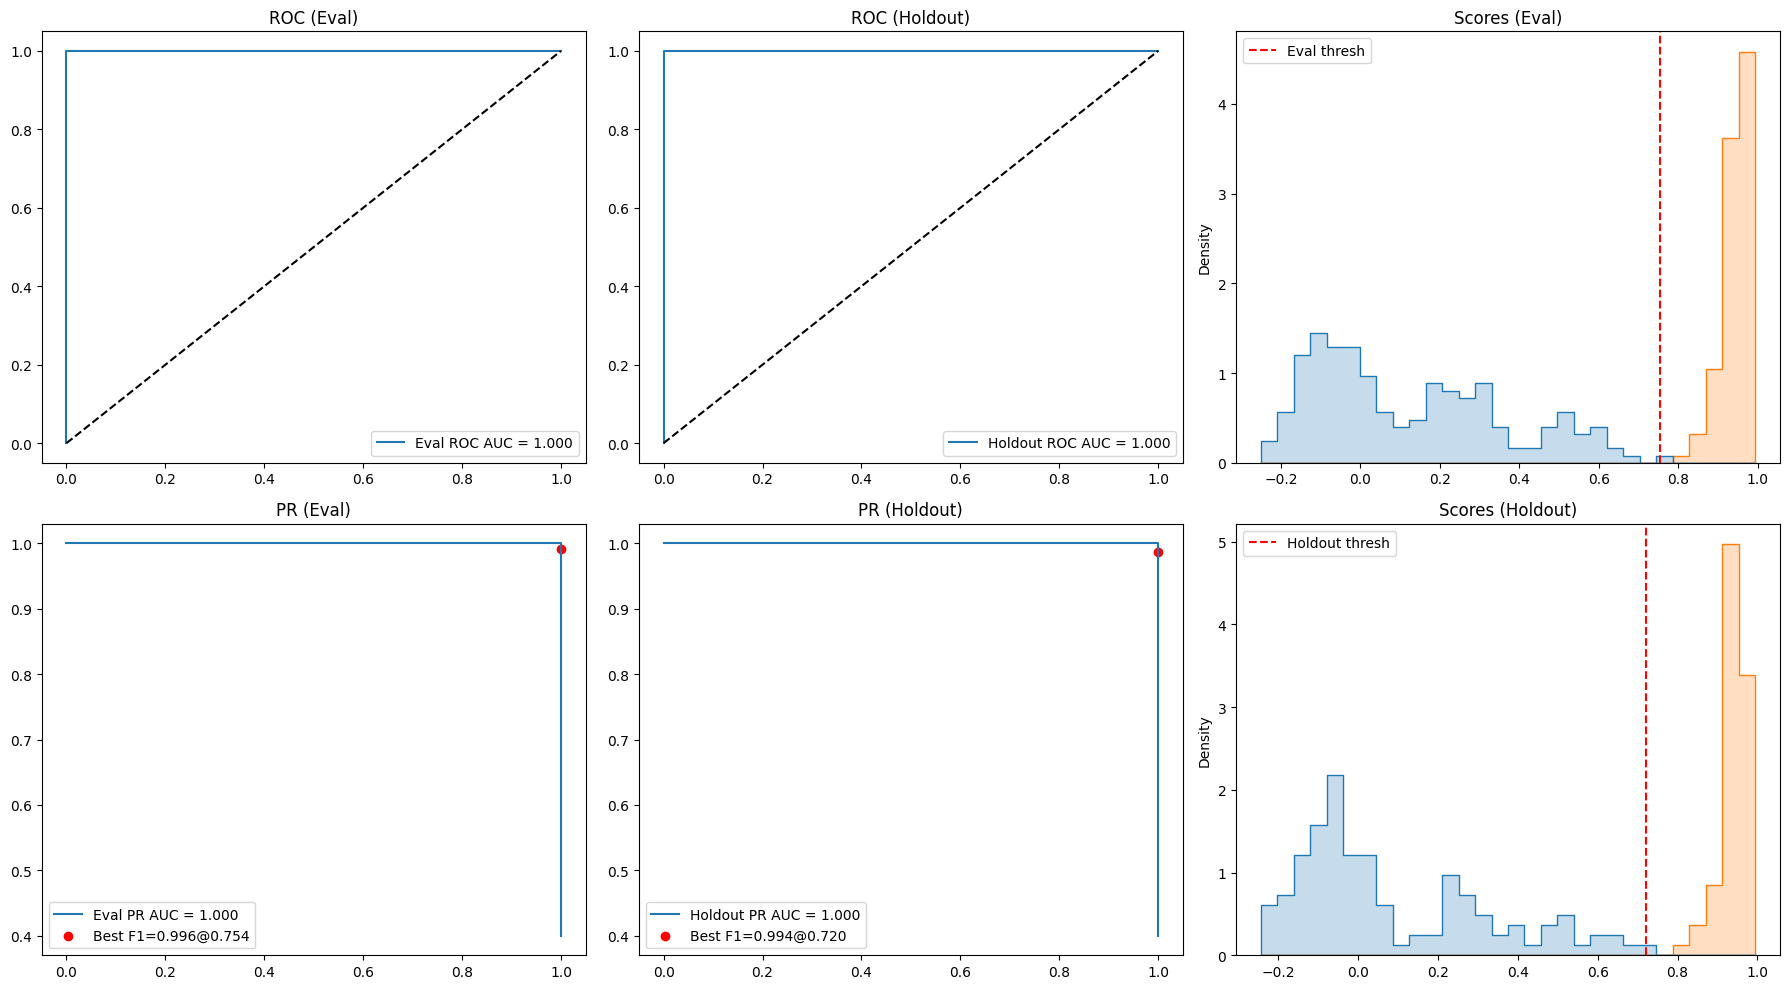

In [7]:

# --- Evaluation Metrics & Plots ---
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.metrics import (
    roc_curve,
    precision_recall_curve,
    roc_auc_score,
    average_precision_score,
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    confusion_matrix,
)

if 'best_model' not in globals():
    best_model = SentenceTransformer(str(save_path))

def run_eval(examples, name="eval"):
    texts1 = [ex.texts[0] for ex in examples]
    texts2 = [ex.texts[1] for ex in examples]
    labels = np.array([ex.label for ex in examples])
    emb1 = best_model.encode(texts1, batch_size=CONFIG['batch_size'], show_progress_bar=True, convert_to_numpy=True)
    emb2 = best_model.encode(texts2, batch_size=CONFIG['batch_size'], show_progress_bar=True, convert_to_numpy=True)
    scores = np.sum(emb1 * emb2, axis=1) / (np.linalg.norm(emb1, axis=1) * np.linalg.norm(emb2, axis=1))
    roc_auc = roc_auc_score(labels, scores)
    pr_auc = average_precision_score(labels, scores)
    fpr, tpr, _ = roc_curve(labels, scores)
    precision, recall, pr_thresh = precision_recall_curve(labels, scores)
    f1_candidates = 2 * (precision * recall) / (precision + recall + 1e-12)
    best_idx = int(np.nanargmax(f1_candidates))
    best_thresh = pr_thresh[best_idx-1] if 0 < best_idx < len(pr_thresh)+1 else 0.5
    preds = (scores >= best_thresh).astype(int)
    prec_at_best = precision_score(labels, preds)
    rec_at_best = recall_score(labels, preds)
    f1_at_best = f1_score(labels, preds)
    acc_at_best = accuracy_score(labels, preds)
    cm = confusion_matrix(labels, preds)
    log(
        f"[{name}] ROC_AUC={roc_auc:.4f}, PR_AUC={pr_auc:.4f}, "
        f"F1@best={f1_at_best:.4f}, P@best={prec_at_best:.4f}, R@best={rec_at_best:.4f}, "
        f"Acc={acc_at_best:.4f}, Thresh={best_thresh:.3f}"
    )
    return {
        'labels': labels,
        'scores': scores,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'fpr': fpr,
        'tpr': tpr,
        'precision': precision,
        'recall': recall,
        'best_thresh': best_thresh,
        'prec_at_best': prec_at_best,
        'rec_at_best': rec_at_best,
        'f1_at_best': f1_at_best,
        'acc_at_best': acc_at_best,
        'cm': cm,
    }

# Eval on validation pairs
res_eval = run_eval(eval_examples, name="eval")
# Eval on holdout pairs (harder negatives)
res_holdout = run_eval(holdout_examples, name="holdout")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
# ROC
axes[0,0].plot(res_eval['fpr'], res_eval['tpr'], label=f"Eval ROC AUC = {res_eval['roc_auc']:.3f}")
axes[0,0].plot([0,1],[0,1],'k--')
axes[0,0].set_title('ROC (Eval)')
axes[0,0].legend()
axes[0,1].plot(res_holdout['fpr'], res_holdout['tpr'], label=f"Holdout ROC AUC = {res_holdout['roc_auc']:.3f}")
axes[0,1].plot([0,1],[0,1],'k--')
axes[0,1].set_title('ROC (Holdout)')
axes[0,1].legend()
# PR
axes[1,0].plot(res_eval['recall'], res_eval['precision'], label=f"Eval PR AUC = {res_eval['pr_auc']:.3f}")
axes[1,0].scatter(res_eval['rec_at_best'], res_eval['prec_at_best'], color='red', label=f"Best F1={res_eval['f1_at_best']:.3f}@{res_eval['best_thresh']:.3f}")
axes[1,0].set_title('PR (Eval)')
axes[1,0].legend()
axes[1,1].plot(res_holdout['recall'], res_holdout['precision'], label=f"Holdout PR AUC = {res_holdout['pr_auc']:.3f}")
axes[1,1].scatter(res_holdout['rec_at_best'], res_holdout['prec_at_best'], color='red', label=f"Best F1={res_holdout['f1_at_best']:.3f}@{res_holdout['best_thresh']:.3f}")
axes[1,1].set_title('PR (Holdout)')
axes[1,1].legend()
# Score distributions
sns.histplot(x=res_eval['scores'], hue=res_eval['labels'], bins=30, stat='density', element='step', ax=axes[0,2])
axes[0,2].axvline(res_eval['best_thresh'], color='red', linestyle='--', label='Eval thresh')
axes[0,2].set_title('Scores (Eval)')
axes[0,2].legend()
sns.histplot(x=res_holdout['scores'], hue=res_holdout['labels'], bins=30, stat='density', element='step', ax=axes[1,2])
axes[1,2].axvline(res_holdout['best_thresh'], color='red', linestyle='--', label='Holdout thresh')
axes[1,2].set_title('Scores (Holdout)')
axes[1,2].legend()
plt.tight_layout()
plt.show()


# 🔬 Overfitting Diagnostic: Testing Category Leakage Hypothesis

**Hypothesis**: The model achieves high metrics by matching category prefixes, not learning semantic content similarity.

**Test Strategy**:
1. Create "adversarial" evaluation pairs:
   - **Hard Positives**: Cross-category pairs with HIGH content similarity (TF-IDF > 0.6)
   - **Hard Negatives**: Same-category pairs with LOW content similarity (TF-IDF < 0.3)
2. If the model is truly learning semantics, it should score these correctly
3. If it's exploiting category shortcuts, metrics will collapse

In [8]:
# Diagnostic: Test if model is exploiting category shortcuts
print("🔬 OVERFITTING DIAGNOSTIC: Testing Category Leakage")
print("="*80)

# Use all incidents for this diagnostic (more data = better test)
all_incidents = df_incidents.reset_index(drop=True)

# Recompute TF-IDF on full dataset for fair comparison
diag_sim_calc = TextSimilarityCalculator(all_incidents['text'].tolist())

# Generate adversarial pairs
hard_positives = []  # Cross-category but semantically similar (high TF-IDF)
hard_negatives = []  # Same-category but semantically dissimilar (low TF-IDF)

print("\n⚙️  Generating adversarial pairs...")
attempts = 0
max_attempts = 50000

while (len(hard_positives) < 200 or len(hard_negatives) < 200) and attempts < max_attempts:
    attempts += 1
    i1, i2 = random.sample(range(len(all_incidents)), 2)
    
    cat1 = all_incidents.at[i1, 'category_id']
    cat2 = all_incidents.at[i2, 'category_id']
    tfidf_sim = diag_sim_calc.get_tfidf_similarity(i1, i2)
    
    # Hard Positive: Different category but HIGH content similarity
    if len(hard_positives) < 200 and cat1 != cat2 and tfidf_sim > 0.6:
        hard_positives.append(InputExample(
            texts=[all_incidents.at[i1, 'text'], all_incidents.at[i2, 'text']], 
            label=1.0  # Should be similar (based on content)
        ))
    
    # Hard Negative: Same category but LOW content similarity
    if len(hard_negatives) < 200 and cat1 == cat2 and tfidf_sim < 0.3:
        hard_negatives.append(InputExample(
            texts=[all_incidents.at[i1, 'text'], all_incidents.at[i2, 'text']], 
            label=0.0  # Should be dissimilar (based on content)
        ))

print(f"✅ Generated {len(hard_positives)} hard positives, {len(hard_negatives)} hard negatives")

adversarial_examples = hard_positives + hard_negatives
print(f"Total adversarial pairs: {len(adversarial_examples)}")

# Evaluate model on adversarial pairs
if len(adversarial_examples) > 0:
    print("\n📊 Evaluating on adversarial pairs...")
    adv_results = run_eval(adversarial_examples, name="adversarial")
    
    print("\n" + "="*80)
    print("🎯 DIAGNOSIS SUMMARY:")
    print("="*80)
    print(f"Standard Eval Spearman:     {res_eval.get('roc_auc', 'N/A'):.4f} (ROC-AUC as proxy)")
    print(f"Adversarial Eval ROC-AUC:   {adv_results['roc_auc']:.4f}")
    print(f"Adversarial Eval PR-AUC:    {adv_results['pr_auc']:.4f}")
    print(f"Adversarial F1 @ best:      {adv_results['f1_at_best']:.4f}")
    
    if adv_results['roc_auc'] < 0.6 or adv_results['f1_at_best'] < 0.5:
        print("\n❌ VERDICT: MODEL IS EXPLOITING CATEGORY SHORTCUTS!")
        print("   → The model fails when category labels don't align with content similarity")
        print("   → It's learning category prefix matching, not semantic understanding")
        print("\n💡 RECOMMENDATIONS:")
        print("   1. Remove explicit [Category | Subcategory] from text, or move to end")
        print("   2. Generate pairs based on TF-IDF similarity, not category matching")
        print("   3. Increase training epochs to 3-5 after fixing pair generation")
        print("   4. Add more hard negatives (same category, low similarity)")
    else:
        print("\n✅ VERDICT: Model shows robustness to category misalignment")
        print("   → Performance holds even when categories don't predict similarity")
        print("   → Model is learning semantic content beyond category shortcuts")
else:
    print("⚠️  Could not generate enough adversarial pairs for diagnostic")

🔬 OVERFITTING DIAGNOSTIC: Testing Category Leakage
⏳ Fitting TF-IDF for similarity mining...
✅ TF-IDF fit complete. Matrix shape: (10000, 110)

⚙️  Generating adversarial pairs...
✅ TF-IDF fit complete. Matrix shape: (10000, 110)

⚙️  Generating adversarial pairs...
✅ Generated 200 hard positives, 200 hard negatives
Total adversarial pairs: 400

📊 Evaluating on adversarial pairs...
✅ Generated 200 hard positives, 200 hard negatives
Total adversarial pairs: 400

📊 Evaluating on adversarial pairs...


Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

[adversarial] ROC_AUC=0.0000, PR_AUC=0.3081, F1@best=0.0952, P@best=0.0909, R@best=0.1000, Acc=0.0500, Thresh=0.500

🎯 DIAGNOSIS SUMMARY:
Standard Eval Spearman:     1.0000 (ROC-AUC as proxy)
Adversarial Eval ROC-AUC:   0.0000
Adversarial Eval PR-AUC:    0.3081
Adversarial F1 @ best:      0.0952

❌ VERDICT: MODEL IS EXPLOITING CATEGORY SHORTCUTS!
   → The model fails when category labels don't align with content similarity
   → It's learning category prefix matching, not semantic understanding

💡 RECOMMENDATIONS:
   1. Remove explicit [Category | Subcategory] from text, or move to end
   2. Generate pairs based on TF-IDF similarity, not category matching
   3. Increase training epochs to 3-5 after fixing pair generation
   4. Add more hard negatives (same category, low similarity)


In [9]:

import json
import torch

# --- Relationship Classifier (Optional) ---
# Runs only if imbalanced-learn is available and relationship data exists.
try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
except ImportError:
    IMBLEARN_AVAILABLE = False

if IMBLEARN_AVAILABLE:
    rel_data_path = None
    try:
        rel_data_path = resolve_data_path(CONFIG['relationship_data'])
    except FileNotFoundError:
        log(f"⚠️ Relationship data not found at {CONFIG['relationship_data']}. Skipping classifier training.", level=logging.WARNING)

    if rel_data_path and rel_data_path.exists():
        log('🧠 Training Relationship Classifier...')
        with open(rel_data_path, 'r') as f:
            rel_data = json.load(f)

        rel_df = pd.DataFrame(rel_data)
        valid_labels = ['duplicate', 'causal', 'related', 'none']
        rel_df = rel_df[rel_df['label'].isin(valid_labels)]
        log(f"Relationship samples after filtering: {len(rel_df)}")

        if len(rel_df) > 0:
            text_a = rel_df['text_a'].tolist()
            text_b = rel_df['text_b'].tolist()

            device_enc = 'cuda' if torch.cuda.is_available() else 'cpu'
            log(f"⏳ Encoding relationship data with the best model on device={device_enc}...")
            emb_a = best_model.encode(text_a, batch_size=CONFIG['batch_size'], show_progress_bar=True, device=device_enc)
            emb_b = best_model.encode(text_b, batch_size=CONFIG['batch_size'], show_progress_bar=True, device=device_enc)

            # Feature Engineering: (u, v, |u-v|, u*v)
            X = np.hstack([emb_a, emb_b, np.abs(emb_a - emb_b), emb_a * emb_b])
            y = rel_df['label']

            from sklearn.linear_model import LogisticRegression
            from sklearn.model_selection import train_test_split
            from sklearn.metrics import classification_report

            if len(np.unique(y)) > 1 and len(X) > 1 and len(np.unique(y)) < len(X):
                smote = SMOTE(k_neighbors=min(2, len(X) - 1), random_state=CONFIG['seed'])
                X_res, y_res = smote.fit_resample(X, y)
                log(f"After SMOTE: {len(X_res)} samples")
            else:
                X_res, y_res = X, y
                log("⚠️ Skipping SMOTE due to insufficient samples or single class after filtering.", level=logging.WARNING)

            clf = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=CONFIG['seed'], solver='lbfgs')
            X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=CONFIG['seed'], stratify=y_res)

            log("⏳ Training Logistic Regression classifier...")
            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            log("✅ Relationship Classifier Report:")
            log(f"{classification_report(y_test, y_pred)}")

            import joblib
            classifier_save_path = save_path / "relationship_classifier.joblib"
            joblib.dump(clf, classifier_save_path)
            log(f"✅ Relationship classifier saved to: {classifier_save_path}")
        else:
            log("⚠️ No valid relationship samples to train classifier. Skipping.", level=logging.WARNING)
    else:
        log(f"⚠️ Relationship data not found at resolved path '{rel_data_path}'. Skipping classifier training.", level=logging.WARNING)
else:
    log('⚠️ imbalanced-learn not installed. Skipping relationship classifier.', level=logging.WARNING)


🧠 Training Relationship Classifier...
Relationship samples after filtering: 861575
⏳ Encoding relationship data with the best model on device=cuda...
Relationship samples after filtering: 861575
⏳ Encoding relationship data with the best model on device=cuda...


Batches:   0%|          | 0/53849 [00:00<?, ?it/s]

KeyboardInterrupt: 

# 🔧 Recommended Fixes for Category Leakage

## Option 1: Content-Based Pairing (Recommended)
Generate pairs based on **content similarity (TF-IDF)** rather than category matching:
- **Positives**: TF-IDF > 0.5 (regardless of category)
- **Negatives**: TF-IDF < 0.3 (regardless of category)

## Option 2: Restructure Text Format
Move category info to the end or remove it entirely:
```python
# Instead of:  [Category] Description
# Use:         Description. (Context: Category)
```

## Option 3: Hybrid Approach
Keep category context but balance pair generation:
- 50% positives: same category + high TF-IDF
- 25% hard positives: cross-category + high TF-IDF  
- 25% hard negatives: same category + low TF-IDF

This forces the model to learn beyond category shortcuts.

In [ ]:
# IMPROVED PAIR GENERATION: Content-based with hard examples
def generate_robust_pairs(df, target_count, config):
    """
    Generates pairs that force the model to learn semantic content,
    not just category matching shortcuts.
    
    Strategy:
    - 40% positives: high TF-IDF (>0.5) - can be same OR cross category
    - 30% hard negatives: same category but low TF-IDF (<0.3)
    - 30% easy negatives: cross category and low TF-IDF
    """
    df = df.reset_index(drop=True)
    sim_calculator = TextSimilarityCalculator(df['text'].tolist())
    
    # Targets for each pair type
    pos_target = int(target_count * 0.4)
    hard_neg_target = int(target_count * 0.3)
    easy_neg_target = target_count - pos_target - hard_neg_target
    
    pairs = []
    groups = df.groupby('category_id').indices
    valid_groups = {k: list(v) for k, v in groups.items() if len(v) >= 2}
    all_indices = list(df.index)
    
    log(f"🔎 Generating {pos_target} content-based positives, "
        f"{hard_neg_target} hard negatives, {easy_neg_target} easy negatives...")
    
    # 1. POSITIVES: High content similarity (TF-IDF > 0.5)
    pbar = tqdm(total=pos_target, desc="Content-Based Positives")
    attempts = 0
    max_attempts = pos_target * 20
    
    while len(pairs) < pos_target and attempts < max_attempts:
        attempts += 1
        i1, i2 = random.sample(all_indices, 2)
        if i1 == i2:
            continue
        
        sim = sim_calculator.get_tfidf_similarity(i1, i2)
        if sim > 0.5:  # High content similarity
            pairs.append(InputExample(
                texts=[df.at[i1, 'text'], df.at[i2, 'text']], 
                label=1.0
            ))
            pbar.update(1)
    pbar.close()
    
    # 2. HARD NEGATIVES: Same category but low similarity (< 0.3)
    current_len = len(pairs)
    pbar = tqdm(total=hard_neg_target, desc="Hard Negatives (same cat)")
    attempts = 0
    max_attempts = hard_neg_target * 20
    
    while (len(pairs) - current_len) < hard_neg_target and attempts < max_attempts:
        attempts += 1
        if not valid_groups:
            break
        
        gid = random.choice(list(valid_groups.keys()))
        g_idxs = valid_groups[gid]
        if len(g_idxs) < 2:
            continue
        
        i1, i2 = random.sample(g_idxs, 2)
        sim = sim_calculator.get_tfidf_similarity(i1, i2)
        
        if sim < 0.3:  # Same category but dissimilar content
            pairs.append(InputExample(
                texts=[df.at[i1, 'text'], df.at[i2, 'text']], 
                label=0.0
            ))
            pbar.update(1)
    pbar.close()
    
    # 3. EASY NEGATIVES: Different category and low similarity
    current_len = len(pairs)
    pbar = tqdm(total=easy_neg_target, desc="Easy Negatives (diff cat)")
    attempts = 0
    max_attempts = easy_neg_target * 20
    
    while (len(pairs) - current_len) < easy_neg_target and attempts < max_attempts:
        attempts += 1
        i1, i2 = random.sample(all_indices, 2)
        
        if df.at[i1, 'category_id'] != df.at[i2, 'category_id']:
            sim = sim_calculator.get_tfidf_similarity(i1, i2)
            if sim < 0.3:
                pairs.append(InputExample(
                    texts=[df.at[i1, 'text'], df.at[i2, 'text']], 
                    label=0.0
                ))
                pbar.update(1)
    pbar.close()
    
    log(f"✅ Generated {len(pairs)} robust training pairs")
    pos_count = sum(1 for p in pairs if p.label == 1.0)
    log(f"   Positives: {pos_count}, Negatives: {len(pairs) - pos_count}")
    
    return pairs

# EXAMPLE: Regenerate training data with robust pairs
# Uncomment below to retrain with improved pairs:
#
# log("🔄 Regenerating training pairs with content-based strategy...")
# train_examples_v2 = generate_robust_pairs(train_incidents_df, train_num_pairs, CONFIG)
# eval_examples_v2 = generate_robust_pairs(eval_incidents_df, eval_num_pairs, CONFIG)
# 
# # Then retrain model with these new pairs (increase epochs to 3-5)
# CONFIG['epochs'] = 3